In [25]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import re


In [26]:
df = pd.read_csv('/Users/kim-yongjun/Documents/부스트캠프 AI Tech 7기/5.5. NLP 기초 프로젝트/nlp_project/train.csv')
tokenizer = transformers.AutoTokenizer.from_pretrained('klue/bert-base')

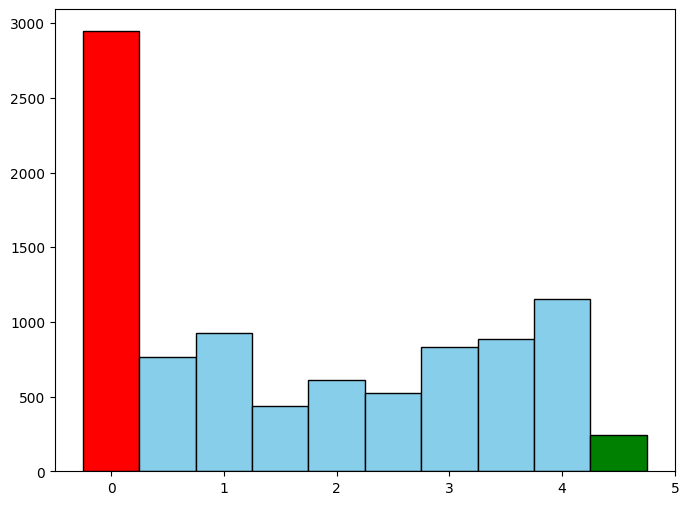

In [27]:
cnt, bins = np.histogram(df['label'], bins = 10)
max_bin_index = np.argmax(cnt)
min_bin_index = np.argmin(cnt)
colors = ['skyblue' for _ in range(10)]
colors[max_bin_index] = 'red'
colors[min_bin_index] = 'green'
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.bar(bins[i], cnt[i], width=(bins[1] - bins[0]), color=colors[i], edgecolor='black')


## 단어의 라벨 분포를 살펴보니, label = 0인 데이터가 상당히 많음을 알 수 있다.
## 모델이 잘 학습하기 위해서는 label의 편향이 적을수록 좋으므로 나중에 label의 분포를 고루 퍼지도록 해야한다

In [28]:
person = df[df['sentence_1'].str.contains('<PERSON>')|df['sentence_2'].str.contains('<PERSON>')]
person[['sentence_1', 'sentence_2']]
print('발견된 <PERSON> 횟수 :', len(person))
print(round(len(person) / len(df) * 100, 4, ), '% 의 데이터에 <PERSON> 이 존재합니다.')
ids = tokenizer('<PERSON>')['input_ids']
for id in ids:
    print(tokenizer.decode(id), end = ' ')

발견된 <PERSON> 횟수 : 138
1.4801 % 의 데이터에 <PERSON> 이 존재합니다.
[CLS] < PER ##S ##ON > [SEP] 

## 데이터를 살펴보니, sentence_1, sentence_2 컬럼의 문장들에 'PERSON'이라는 단어가 꽤 많이 등장함을 알 수 있었다.
## 모델은 Bert-base기준 <PERSON>이라는 단어는 하나의 토큰으로 분류돼 있지 않다.
## 이는 모델의 학습에 악영향을 끼칠 수 있음으로 추후 조치가 필요하다.

In [29]:
def has_english(sentence):
    pattern = '[a-zA-Z]'
    b = bool(re.search(pattern, sentence))
    return b

sample = df[ (df['sentence_1'].apply(has_english)) | (df['sentence_2'].apply(has_english))].sample(30)
sample

,id,source,sentence_1,sentence_2,label,binary-label
873,boostcamp-sts-v1-train-873,petition-sampled,강서 pc방 알바생 살인사건 범인 신상공개,강서구PC방 살인사건 피의자 신상공개해주시죠,3.8,1.0
2892,boostcamp-sts-v1-train-2892,nsmc-sampled,너무 기대해서 봤나.... 정말 실망..;;,너무 SF적으로 변해서 실망...,2.2,0.0
5436,boostcamp-sts-v1-train-5436,slack-sampled,"이번에 우리 회사를 통해 기업 고객, 내부 구성원들 뿐만 아니라 AI 생태계에 기여...","포부는 우리 회사 팀원분들과 함께 AI 팩 개발 잘 되게 하고 싶다고 하시는데, 벌...",0.8,0.0
3924,boostcamp-sts-v1-train-3924,petition-rtt,"e-sports나 아시안게임, 월드컵에서 1등을 하면 군대를 안가듯이 다른 국제 대...",e스포츠나 아시안게임이나 월드컵에서 1등을 하면 군대에 가지 않는 것처럼 다른 국제...,4.4,1.0
70,boostcamp-sts-v1-train-070,slack-sampled,<PERSON> 님과 어제 저녁에 식사를 하였습니다!,<PERSON> 님과 어제 한시간동안 이야기 나눴습니다!!,0.8,0.0
1070,boostcamp-sts-v1-train-1070,slack-sampled,<PERSON> 와 금요일에 이야기 나누었습니다.,<PERSON> 님과 처음으로 이야기 나누었습니다.,2.6,1.0
6396,boostcamp-sts-v1-train-6396,petition-rtt,어린이집 cctv 핸드폰으로 실시간으로 볼수 있게 해주십시오.,어린이집 cctv를 휴대폰으로 실시간으로 볼 수 있도록 해주세요.,4.6,1.0
5489,boostcamp-sts-v1-train-5489,petition-sampled,갑질을금지시켜주세요,GS건설 갑질을 엄벌해주세요.,1.0,0.0
5518,boostcamp-sts-v1-train-5518,slack-sampled,"비즈니스적인 관점에서 제가 맡고 있는 CE팀 업무에 대한 이야기도 했는데요, 여러모...",라운지에서 공짜 커피를 마시면서 여러 이야기를 들었는데 비즈팀분들의 이야기는 제가 ...,0.4,0.0
294,boostcamp-sts-v1-train-294,slack-rtt,<PERSON> 님과 지난주 산책했습니다!,지난주에 <PERSON>님과 산책을 다녀왔어요!,4.2,1.0


## 영어를 포함한 데이터 중, 대문자와 소문자가 섞여 모델의 훈련에 혼란을 줄 수 있어 전부 소문자로 바꾸는 것이 도움이 될 것임을 알 수 있다. ex) pc방, PC방, lg, LG 등



In [30]:
import re
def has_repeated_words(sentence):
    # 정규 표현식: 같은 단어가 3번 이상 연속으로 나오는지 확인
    pattern = r'\b(\w+)\b\s+\1\s+\1'
    b1 = bool(re.search(pattern, sentence))
    pattern = r'(\w+)\1\1'
    b2 = bool(re.search(pattern, sentence))
    if b1 or b2 and not re.search(r'(ㅋㅋㅋ|ㅎㅎㅎ)', sentence):
        return True
    else:
        return False
    

repeated_df = df[df['sentence_1'].apply(has_repeated_words) | df['sentence_2'].apply(has_repeated_words)]
print('같은 단어가 반복되는 문장 수 :', len(repeated_df))
repeated_df[['sentence_1','sentence_2']].sample(20)

같은 단어가 반복되는 문장 수 : 124


,sentence_1,sentence_2
4965,와 이정도면 해낸것과 진배없!! ㅎㅎ,와. 초초초 대대대박!!
4076,아 망했어요....,아.............. 내 돈..............................
5034,(요즘 이사 준비하느라 옷을 뒤져서 싹 버려야한다는 말씀을 드리려다가.. 호롤롤롤 ...,(요즘 이사 준비하면서 옷 정리하고 버려야 한다고 해서.. 이야기가 점점 길어지네요...
1026,시간빠르네요!!! ㅠㅠㅠ,ㅎㅎㅎ시간 진짜 넘 금방갔어요!!!
9068,다들 너무 사랑스럽네요,ㅠㅠㅠ 너무 이쁘네요
6041,편은 그래도 볼만했는데.. 편은 완전 막장,편은 재밌었는데 편은 막장으로 고고고
3372,안주로 채고채고...,와아아아우 체고체고!!!
6792,ㄹㅇ꿀잼 이건 봐야합니다,개웃겨 ㅋㅋ 꿀잼잼잼ㅋㅋ
2458,진짜 재미있었어요 영원한 힐러ㅠㅠㅠ,진짜 재미있어요 ㅠㅠ!
2619,재미없진않네요 하하하,너무 재미없었어요^-^


## 정규식을 통해 같은 글자가 세 번 이상 반복되는 문장들이 124개 가량 존재했음을 발견하였다. (ㅋㅋㅋ, ㅎㅎㅎ와 같이 자주 반복되는 단어 외에도 많았음.)

## 이는 마찬가지로 모델의 학습에 불필요한 요소이므로 3번 이상 반복되는 단어들의 처리가 필요함을 알 수 있다.

In [31]:
cnt1, bins = np.histogram(df['sentence_1'].apply(lambda x: len(max(x.split()))), bins = 20)
cnt2, bins = np.histogram(df['sentence_2'].apply(lambda x: len(max(x.split()))), bins = 20)
cnt = cnt1 + cnt2

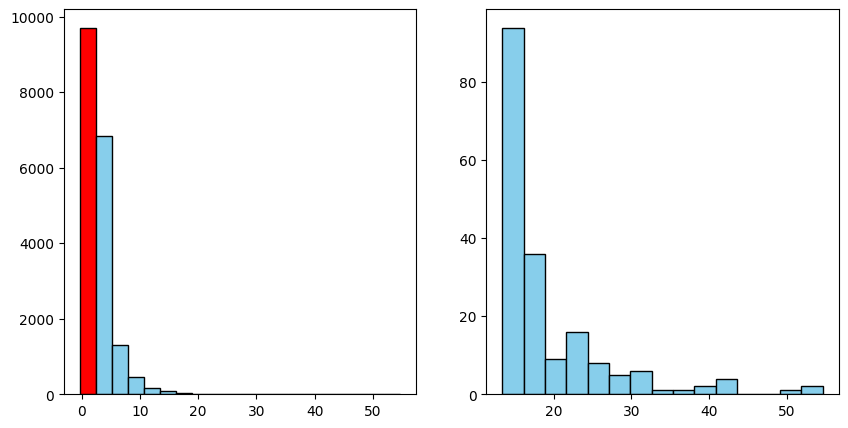

In [32]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
max_bin_index = np.argmax(cnt)
min_bin_index = np.argmin(cnt)
colors = ['skyblue' for _ in range(20)]
colors[max_bin_index] = 'red'
colors[min_bin_index] = 'green'
for i in range(20):
    axes[0].bar(bins[i], cnt[i], width = (bins[1] - bins[0]), color=colors[i], edgecolor='black')
for i in range(5,20,1):
    axes[1].bar(bins[i], cnt[i], width = (bins[1] - bins[0]), color=colors[i], edgecolor = 'black')


## 문장의 단어들을 띄어쓰기 기준으로 분리한 후 가장 긴 단어를 봤을 때, 대부분의 단어는 정상적으로 1~7정도의 단어 길이를 가지고 있었지만,
## 몇몇의 단어들의 길이가 10 이상인 것을 발견하였다.
## 이는 띄어쓰기가 제대로 이루어지지 않은 단어가 존재함을 암시한다.

In [33]:
from collections import defaultdict
def find_unk_words(sentence):
    unk_list = []
    sentences = sentence.split()
    for word in sentences:
        if tokenizer.encode(word)[1] == tokenizer.unk_token_id:
            unk_list.append(word)
    return unk_list
unk_in_sentence_1 = df['sentence_1'].apply(find_unk_words)
unk_in_sentence_2 = df['sentence_2'].apply(find_unk_words)
unk_in_sentence_1 = unk_in_sentence_1.value_counts()[1:]
unk_in_sentence_2 = unk_in_sentence_2.value_counts()[1:]
sentence_1_tokens_len = df['sentence_1'].apply(lambda x:len(tokenizer(x)['input_ids'])).sum()
sentence_2_tokens_len = df['sentence_2'].apply(lambda x:len(tokenizer(x)['input_ids'])).sum()
all_tokens_len = sentence_1_tokens_len + sentence_2_tokens_len
d = defaultdict(int)
for sentence in unk_in_sentence_1.index:
    for word in sentence:
        d[word] += 1
for sentence in unk_in_sentence_2.index:
    for word in sentence:
        d[word] += 1

d = dict(sorted(d.items(), key = lambda x:x[1],reverse = True))
print('다양한 [UNK] 토큰들 :',list(d)[:12])
print('[UNK] 토큰의 개수 ;', sum(d.values()))
print('전체 토큰들 중 [UNK] 토큰의 비율:', 100 * sum(d.values()) / (all_tokens_len - sum(d.values())), '%')

다양한 [UNK] 토큰들 : ['넵', '뵐', '넵.', '앜ㅋㅋ', '쑈!', '뵌', '봣는데', '시킵시다.', '왤케', '네넵!', '넵!', '넵넵!!']
[UNK] 토큰의 개수 ; 429
전체 토큰들 중 [UNK] 토큰의 비율: 0.15460128005535376 %


## 모든 문장에서 Tokenizer가 [UNK] 토큰으로 받아들인 단어들을 빈도수로 내림차순 정렬 한 뒤 12개만 본 결과이다.
## Tokenizer가 잡지 못하는 단어들은 주로 넵, 넵! 등의 단어였으며, 문재인 > 문제인 등의 오타도 포함돼 있었다.

## 정리해보면, 본 데이터는
### 1. Label의 균형을 맞춰야 함.
### 2. 자주 등장하는 'PERSON' 단어를 Tokenizer마다 다르게 해석할 수 있으므로 하나의 Special Token으로 추가해야 함.
### 3. 같은 단어들이 반복되는 문장들을 교정해야 함.
### 4. 대문자들을 전부 소문자로 바꿔 혼란을 줄여야 함.
### 5. 띄어쓰기 교정을 통해 올바른 문장으로 바꿔야 함.
### 6. 오타로 인한 [UNK] Token 생성을 줄여야 함.
### 의 처리들이 필요함을 알 수 있다.